In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!pip install pytorch-tabnet
!pip install ipypb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
np.random.seed(0)

import ast
from tqdm import tqdm as track

import os
from pathlib import Path

from matplotlib import pyplot as plt

# load data

In [5]:
train = pd.read_excel('/content/drive/MyDrive/Tomsk/dataset_train.xlsx')

In [6]:
train.Data = train.Data.apply(lambda x: np.array(ast.literal_eval(x)))
train.Data_2 = train.Data_2.apply(lambda x: np.array(ast.literal_eval(x)))

In [7]:
train['idx'] = list(train.index)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31383 entries, 0 to 31382
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Filename      31383 non-null  object
 1   Test_index    31383 non-null  int64 
 2   Presentation  31383 non-null  int64 
 3   Question      31383 non-null  int64 
 4   Data          31383 non-null  object
 5   Data_2        31383 non-null  object
 6   Class_label   31383 non-null  int64 
 7   idx           31383 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 1.9+ MB


In [9]:
balanced_train = pd.concat([train[train.Class_label.isin([0, 2])],
                            train[train.Class_label == 1].sample(7000)], ignore_index=True)

balanced_train['idx'] = list(balanced_train.index)

In [10]:
balanced_train['Data_max'] = balanced_train.Data.apply(lambda x: np.max(x))
balanced_train['Data_min'] = balanced_train.Data.apply(lambda x: np.min(x))
balanced_train['Data_2_max'] = balanced_train.Data_2.apply(lambda x: np.max(x) if len(x) > 0 else 0)
balanced_train['Data_2_min'] = balanced_train.Data_2.apply(lambda x: np.min(x) if len(x) > 0 else 0)

balanced_train = pd.merge(balanced_train.drop(['Data_max'], axis=1), 
                          balanced_train.groupby(['Filename', 'Test_index', 'Presentation']).Data_max.max().reset_index(), 
                          on=list(balanced_train.columns[:3]), how='left')

balanced_train = pd.merge(balanced_train.drop(['Data_min'], axis=1), 
                          balanced_train.groupby(['Filename', 'Test_index', 'Presentation']).Data_min.min().reset_index(), 
                          on=list(balanced_train.columns[:3]), how='left')

balanced_train = pd.merge(balanced_train.drop(['Data_2_max'], axis=1), 
                          balanced_train.groupby(['Filename', 'Test_index', 'Presentation']).Data_2_max.max().reset_index(), 
                          on=list(balanced_train.columns[:3]), how='left')

balanced_train = pd.merge(balanced_train.drop(['Data_2_min'], axis=1), 
                          balanced_train.groupby(['Filename', 'Test_index', 'Presentation']).Data_2_min.min().reset_index(), 
                          on=list(balanced_train.columns[:3]), how='left')

balanced_train['Data_max'] = balanced_train['Data_max'].max()
balanced_train['Data_min'] = balanced_train['Data_min'].min()
balanced_train['Data_2_max'] = balanced_train['Data_2_max'].max()
balanced_train['Data_2_min'] = balanced_train['Data_2_min'].min()

balanced_train['Data'] = balanced_train.apply(lambda x: (x[4] - x[9]) / (x[8] - x[9]), axis=1)
balanced_train['Data_2'] = balanced_train.apply(lambda x: (x[5] - x[11]) / (x[10] - x[11]), axis=1)

In [11]:
data1 = []
for d in track(balanced_train.Data):
    data1.append(d)
    
data2 = []
for d in track(balanced_train.Data_2):
    data2.append(d)

100%|██████████| 20741/20741 [00:00<00:00, 1736131.14it/s]


In [12]:
data1 = pd.DataFrame(data1).apply(lambda x: x.fillna(np.nanmean(x)))
data2 = pd.DataFrame(data2).apply(lambda x: x.fillna(np.nanmean(x)))

data1 = data1.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
data2 = data2.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

data1.to_numpy()
data2.to_numpy()

array([[0.60622222, 0.62457875, 0.65366296, ..., 0.63776123, 0.65373832,
        0.66194286],
       [0.55377778, 0.61334532, 0.66001361, ..., 0.63487869, 0.64018692,
        0.64297143],
       [0.33488889, 0.35385307, 0.37695623, ..., 0.29618064, 0.29836449,
        0.30994286],
       ...,
       [0.44955556, 0.43855313, 0.45860739, ..., 0.54143646, 0.69953271,
        0.75702857],
       [0.58955556, 0.57919569, 0.58879565, ..., 0.54912323, 0.54626168,
        0.57622857],
       [0.656     , 0.66883846, 0.68019959, ..., 0.55753063, 0.56495327,
        0.59222857]])

In [13]:
np.concatenate([data1, data2], axis=1).shape

(20741, 480)

# feature engineering

In [ ]:
data = np.concatenate([data1.to_numpy()[..., np.newaxis], 
                       data2.to_numpy()[..., np.newaxis]], axis=2)

In [ ]:
data1_cumsum = data1.cumsum(axis=1).to_numpy()
data1_cummax = data1.cummax(axis=1).to_numpy()
data1_cummin = data1.cummin(axis=1).to_numpy()

data2_cumsum = data2.cumsum(axis=1).to_numpy()
data2_cummax = data2.cummax(axis=1).to_numpy()
data2_cummin = data2.cummin(axis=1).to_numpy()

In [ ]:
deriv_shifts = [3, 7, 15, 31, 63]
derivs1 = []

for ds in deriv_shifts:

    deriv = data1[data1.columns[:-ds]].values - data1[data1.columns[ds:]].values
    values_to_fill = data1.shape[1] - deriv.shape[1]
    deriv = np.hstack([deriv, np.zeros((data1.shape[0], values_to_fill))])
    
    derivs1.append(deriv)

In [ ]:
deriv_shifts = [3, 7, 15, 31, 63]
derivs2 = []

for ds in deriv_shifts:

    deriv = data2[data2.columns[:-ds]].values - data2[data2.columns[ds:]].values
    values_to_fill = data2.shape[1] - deriv.shape[1]
    deriv = np.hstack([deriv, np.zeros((data2.shape[0], values_to_fill))])
    
    derivs2.append(deriv)

In [ ]:
windows = [3, 7, 15, 31, 63]

rolling_windows_sum_1 = []
rolling_windows_mean_1 = []
rolling_windows_max_1 = []
rolling_windows_min_1 = []

rolling_windows_sum_2 = []
rolling_windows_mean_2 = []
rolling_windows_max_2 = []
rolling_windows_min_2 = []

for window in track(windows):
    
    rolling_windows_sum_1.append(data1.rolling(window, axis=1).sum().fillna(0).to_numpy())
    rolling_windows_mean_1.append(data1.rolling(window, axis=1).mean().fillna(0).to_numpy())
    rolling_windows_max_1.append(data1.rolling(window, axis=1).max().fillna(0).to_numpy())
    rolling_windows_min_1.append(data1.rolling(window, axis=1).min().fillna(0).to_numpy())
    
    rolling_windows_sum_2.append(data2.rolling(window, axis=1).sum().fillna(0).to_numpy())
    rolling_windows_mean_2.append(data2.rolling(window, axis=1).mean().fillna(0).to_numpy())
    rolling_windows_max_2.append(data2.rolling(window, axis=1).max().fillna(0).to_numpy())
    rolling_windows_min_2.append(data2.rolling(window, axis=1).min().fillna(0).to_numpy())

 [████████████████████████████████████████████████████████████] 5/5 [00:59<00:12, 11.78s/it]

In [ ]:
data = np.concatenate([
    data,
    data1_cumsum[..., np.newaxis],
    data1_cummax[..., np.newaxis],
    data1_cummin[..., np.newaxis],
    data2_cumsum[..., np.newaxis],
    data2_cummax[..., np.newaxis],
    data2_cummin[..., np.newaxis],
], axis=2)

In [ ]:
for deriv in derivs1:
    data = np.concatenate([
        data,
        deriv[..., np.newaxis],
    ], axis=2)

In [ ]:
for deriv in derivs2:
    data = np.concatenate([
        data,
        deriv[..., np.newaxis],
    ], axis=2)

In [ ]:
for rw_ in track([rolling_windows_sum_1, rolling_windows_mean_1, 
                  rolling_windows_max_1, rolling_windows_min_1,
                  rolling_windows_sum_2, rolling_windows_mean_2,
                  rolling_windows_max_2, rolling_windows_min_2]):

    for rw in rw_:
        data = np.concatenate([
            data,
            rw[..., np.newaxis],
        ], axis=2)

In [ ]:
data.shape

(31383, 240, 58)

# model

In [16]:
X_train, X_val, y_train, y_val = train_test_split(np.concatenate([data1, data2], axis=1), 
                                                  balanced_train.Class_label,
                                                  stratify=balanced_train.Class_label,
                                                  test_size=0.15,
                                                  random_state=17)

print(list(y_train.value_counts()))
print(list(y_val.value_counts()))

[5973, 5950, 5706]
[1055, 1050, 1007]


In [18]:
tabnet_params = {
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=1e-2),
                 "scheduler_params":{"step_size":10, # how to use learning rate scheduler
                                     "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params)

Device used : cuda


In [19]:
max_epochs = 100

save_history = []

for _ in range(2):
    
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_name=['train', 'valid'],
        # eval_metric=['accuracy'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        # num_workers=0,
        # weights=1,
        # drop_last=False,
    )
    
    save_history.append(clf.history["valid_accuracy"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 1.24311 | train_accuracy: 0.34903 | valid_accuracy: 0.34672 |  0:00:03s
epoch 1  | loss: 1.15402 | train_accuracy: 0.33887 | valid_accuracy: 0.33837 |  0:00:05s
epoch 2  | loss: 1.12537 | train_accuracy: 0.33819 | valid_accuracy: 0.33901 |  0:00:06s
epoch 3  | loss: 1.11332 | train_accuracy: 0.33643 | valid_accuracy: 0.33772 |  0:00:07s
epoch 4  | loss: 1.1058  | train_accuracy: 0.33893 | valid_accuracy: 0.33933 |  0:00:08s
epoch 5  | loss: 1.10341 | train_accuracy: 0.34517 | valid_accuracy: 0.34704 |  0:00:09s
epoch 6  | loss: 1.10077 | train_accuracy: 0.34914 | valid_accuracy: 0.36857 |  0:00:11s
epoch 7  | loss: 1.0997  | train_accuracy: 0.35124 | valid_accuracy: 0.3615  |  0:00:12s
epoch 8  | loss: 1.09939 | train_accuracy: 0.35612 | valid_accuracy: 0.36536 |  0:00:13s
epoch 9  | loss: 1.09848 | train_accuracy: 0.35493 | valid_accuracy: 0.35283 |  0:00:14s
epoch 10 | loss: 1.09812 | train_accuracy: 0.35714 | valid_accuracy: 0.35668 |  0:00:16s
epoch 11 | loss: 1.09

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


AssertionError: ignored

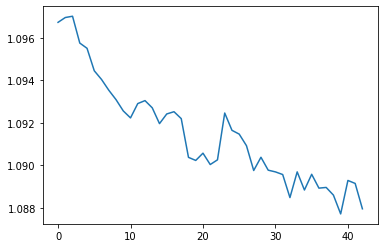

In [20]:
# plot losses
plt.plot(clf.history['loss'])

In [21]:
explain_matrix, masks = clf.explain(X_val)

In [22]:
mask = np.zeros((50, 240))
for i in range(len(masks)):
    mask += masks[i][:50]

ValueError: ignored

In [23]:
X_val.shape

(3112, 480)

In [24]:
masks[0].shape

(3112, 480)

Text(0.5, 1.0, 'label 0')

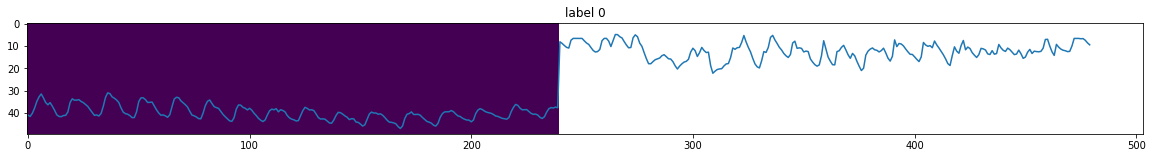

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(20,20))

axs.imshow(mask)
axs.plot(X_val[i]*50)
axs.set_title(f"label {y_val.iloc[0]}")

In [ ]:
# в рамках повторения смотреть на все вопросы
# учесть метрику, которая обращает внимание на грубые ошибки
# попробовать сравнивать попарно

In [ ]:
# Каждая проверка представляет из себя несколько групп вопросов, каждый из которых задается не более 4 раз.

In [ ]:
train[(train.Filename == train.Filename.iloc[0])
      &(train.Presentation == 3)].groupby('Test_index').Question.count()

Test_index
0     4
1     4
2     9
3    10
Name: Question, dtype: int64

In [26]:
!pip install tsai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 241 kB 4.8 MB/s 
     |████████████████████████████████| 2.5 MB 43.8 MB/s 
     |████████████████████████████████| 750.6 MB 11 kB/s 
     |████████████████████████████████| 19.1 MB 459 kB/s 
     |████████████████████████████████| 21.0 MB 1.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cu113
    Uninstalling torch-1.12.0+cu113:
      Successfully uninstalled torch-1.12.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.0+cu113
    Uninstalling torchvision-0.13.0+cu113:
      Successfully uninstalled torchvision-0.13.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.0 requires torch==1.12.0, but you have torch 1.11.0 which is

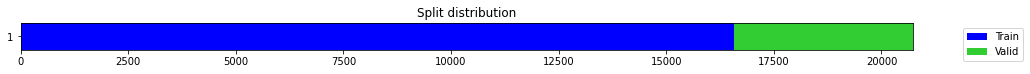

epoch,train_loss,valid_loss,accuracy,time
0,1.043873,1.775272,0.000000,00:22
1,1.040323,2.378648,0.000000,00:22
2,1.031279,1.854027,0.000000,00:22
3,1.035695,1.695277,0.000000,00:22
4,1.036891,1.741190,0.000000,00:22
5,1.035855,1.757030,0.000000,00:22
6,1.034587,1.733163,0.000000,00:22
7,1.030615,1.742965,0.000000,00:22
8,1.034533,1.743021,0.000000,00:22
9,1.023150,1.744078,0.000000,00:22


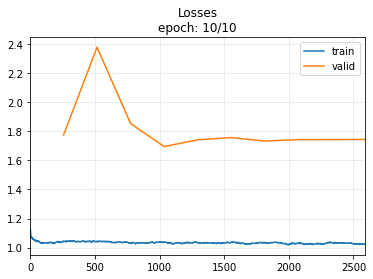

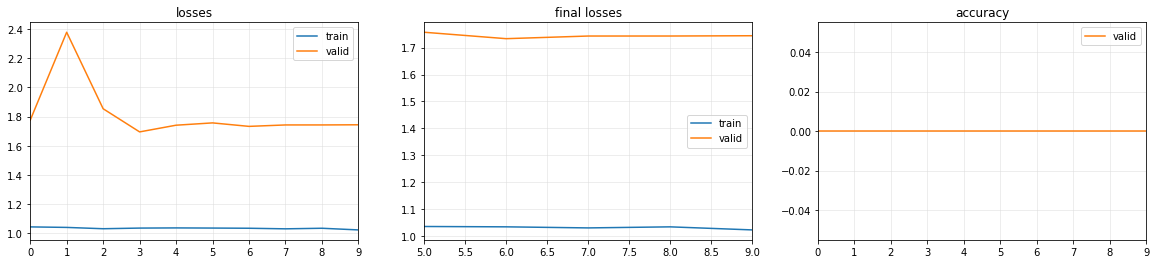

In [29]:
from tsai.all import *

batch_tfms = TSStandardize(by_sample=True)

# X, y = np.concatenate([data1, data2], axis=1), balanced_train.Class_label
X, y = data1, balanced_train.Class_label

mv_clf = TSClassifier(X, y, path='models', 
                      arch=InceptionTimePlus, batch_tfms=batch_tfms, 
                      metrics=accuracy, cbs=ShowGraph())

mv_clf.fit_one_cycle(10, 1e-2)

mv_clf.export("mv_clf.pkl")